This example was adapted from skaae's Lasagne [recipe](https://github.com/skaae/Recipes/blob/spatial_transform/examples/spatial_transformer_network.ipynb).  
You can download skaae's Cluttered MNIST dataset [here](https://s3.amazonaws.com/lasagne/recipes/datasets/mnist_cluttered_60x60_6distortions.npz).
This ipython notebook was adapted from Seya's spatial transformer network example
(https://github.com/EderSantana/seya/blob/keras1/examples/Spatial%20Transformer%20Networks.ipynb)

Reference at [arXiv](http://arxiv.org/abs/1506.02025)

In [1]:
%matplotlib inline

import numpy as np
np.random.seed(1337)  # for reproducibility
import matplotlib.pyplot as plt
from scipy.misc import imresize
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.utils import np_utils
from keras.utils import np_utils, generic_utils
from keras.optimizers import Adam, SGD

import keras.backend as K


batch_size = 128
nb_classes = 10
nb_epoch = 12

DIM = 60
mnist_cluttered = "datasets/mnist_cluttered_60x60_6distortions.npz"

Using TensorFlow backend.


In [2]:
from spatial_transformer import SpatialTransformer

In [3]:
data = np.load(mnist_cluttered)
X_train, y_train = data['x_train'], np.argmax(data['y_train'], axis=-1)
print("X_train sample:", X_train[0])
X_valid, y_valid = data['x_valid'], np.argmax(data['y_valid'], axis=-1)
X_test, y_test = data['x_test'], np.argmax(data['y_test'], axis=-1)
# reshape for convolutions
X_train = X_train.reshape((X_train.shape[0], DIM, DIM, 1))
X_valid = X_valid.reshape((X_valid.shape[0], DIM, DIM, 1))
X_test = X_test.reshape((X_test.shape[0], DIM, DIM, 1))
#one hot
y_train = np_utils.to_categorical(y_train, nb_classes)
y_valid = np_utils.to_categorical(y_valid, nb_classes)
y_test = np_utils.to_categorical(y_test, nb_classes)

print("Train samples: {}".format(X_train.shape))
print("Validation samples: {}".format(X_valid.shape))
print("Test samples: {}".format(X_test.shape))
print("sample output:",y_train)
print("output shape:", y_train.shape)
input_shape =  np.squeeze(X_train.shape[1:])
input_shape = (60,60,1)
print("Input shape:",input_shape)

('X_train sample:', array([ 0.,  0.,  0., ...,  0.,  0.,  0.], dtype=float32))
Train samples: (50000, 60, 60, 1)
Validation samples: (10000, 60, 60, 1)
Test samples: (10000, 60, 60, 1)
('sample output:', array([[ 0.,  0.,  0., ...,  0.,  1.,  0.],
       [ 1.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  1., ...,  0.,  0.,  0.],
       ..., 
       [ 1.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  1.],
       [ 0.,  0.,  0., ...,  1.,  0.,  0.]]))
('output shape:', (50000, 10))
('Input shape:', (60, 60, 1))


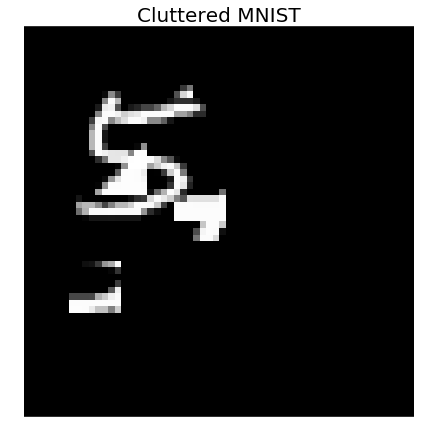

In [4]:
plt.figure(figsize=(7,7))
plt.imshow(X_train[101].reshape(DIM, DIM), cmap='gray', interpolation='none')
plt.title('Cluttered MNIST', fontsize=20)
plt.axis('off')
plt.show()

In [5]:
# initial weights for the localisation network or the finding the transformation matrix
b = np.zeros((2, 3), dtype='float32')
b[0, 0] = 1
b[1, 1] = 1
W = np.zeros((50, 6), dtype='float32')
weights = [W, b.flatten()]

In [6]:
locnet = Sequential()
locnet.add(MaxPooling2D(pool_size=(2,2), input_shape=input_shape))
locnet.add(Convolution2D(20, (5, 5)))
locnet.add(MaxPooling2D(pool_size=(2,2)))
locnet.add(Convolution2D(20, (5, 5)))

locnet.add(Flatten())
locnet.add(Dense(50))
locnet.add(Activation('relu'))
locnet.add(Dense(6, weights=weights))
#locnet.add(Activation('sigmoid'))

In [7]:
model = Sequential()

model.add(SpatialTransformer(localization_net=locnet,
                             output_size=(30,30), input_shape=input_shape))


model.add(Convolution2D(32, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Convolution2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(256))
model.add(Activation('relu'))

model.add(Dense(nb_classes))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])

In [8]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
spatial_transformer_1 (Spati (None, 30, 30, 1)         91896     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 30, 30, 32)        320       
_________________________________________________________________
activation_2 (Activation)    (None, 30, 30, 32)        0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 13, 13, 32)        9248      
_________________________________________________________________
activation_3 (Activation)    (None, 13, 13, 32)        0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 6, 6, 32)          0         
__________

In [9]:
XX = model.input
YY = model.layers[0].output
# to get th output of an intermediate layer i.e. after spatial transformation layer, given the input
F = K.function([XX], [YY])

In [10]:
print(X_train.shape[0]/batch_size)

390


10000/10000 [==============================] - 2s 150us/step
Epoch: 0 | Valid Score: 0.937859751225| Test Score: 0.95330263195| Valid Acc: 0.6982 | Test Acc: 0.6997


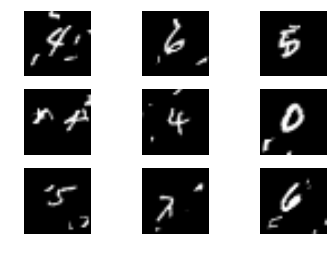

10000/10000 [==============================] - 2s 156us/step
Epoch: 1 | Valid Score: 0.594956743622| Test Score: 0.586658726311| Valid Acc: 0.8125 | Test Acc: 0.8189


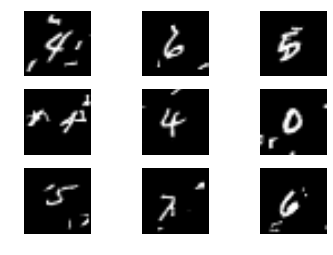

10000/10000 [==============================] - 2s 152us/step
Epoch: 2 | Valid Score: 0.48899225812| Test Score: 0.487494185114| Valid Acc: 0.846 | Test Acc: 0.8444


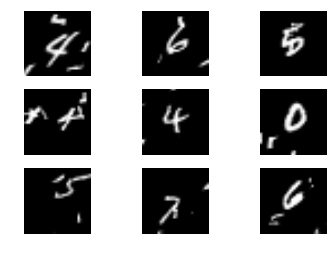

10000/10000 [==============================] - 2s 155us/step
Epoch: 3 | Valid Score: 0.421160487342| Test Score: 0.428427879| Valid Acc: 0.8669 | Test Acc: 0.8648


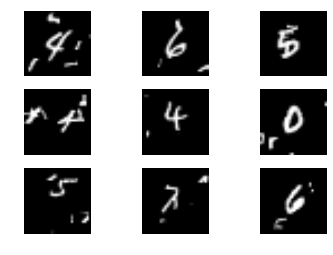

10000/10000 [==============================] - 2s 157us/step
Epoch: 4 | Valid Score: 0.360996624756| Test Score: 0.361668886995| Valid Acc: 0.886 | Test Acc: 0.8884


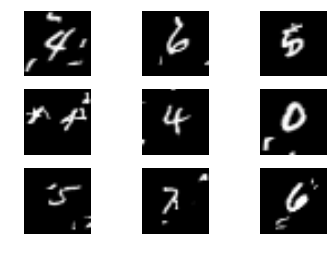

10000/10000 [==============================] - 2s 158us/step
Epoch: 5 | Valid Score: 0.357804605961| Test Score: 0.354219225013| Valid Acc: 0.8863 | Test Acc: 0.8867


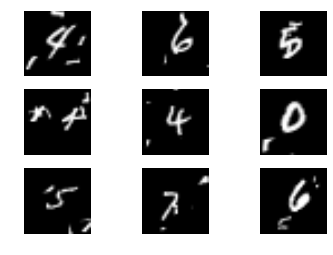

10000/10000 [==============================] - 2s 161us/step
Epoch: 6 | Valid Score: 0.336344791579| Test Score: 0.326634561992| Valid Acc: 0.8934 | Test Acc: 0.8926


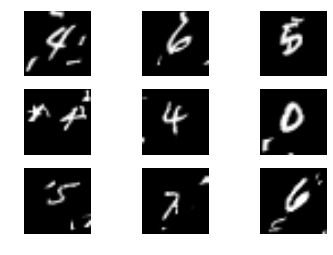

10000/10000 [==============================] - 2s 156us/step
Epoch: 7 | Valid Score: 0.31127990309| Test Score: 0.304488218862| Valid Acc: 0.9016 | Test Acc: 0.9032


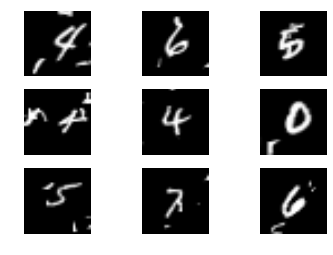

10000/10000 [==============================] - 2s 162us/step
Epoch: 8 | Valid Score: 0.298960393298| Test Score: 0.291784962249| Valid Acc: 0.9035 | Test Acc: 0.9029


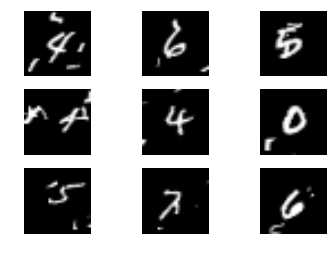

10000/10000 [==============================] - 2s 157us/step
Epoch: 9 | Valid Score: 0.2772718786| Test Score: 0.257980013496| Valid Acc: 0.9114 | Test Acc: 0.9163


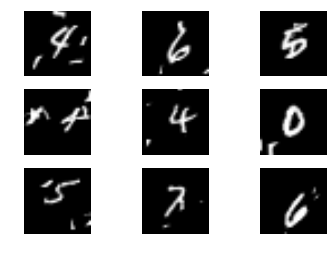

10000/10000 [==============================] - 2s 159us/step
Epoch: 10 | Valid Score: 0.255509131676| Test Score: 0.257289037883| Valid Acc: 0.9175 | Test Acc: 0.9193


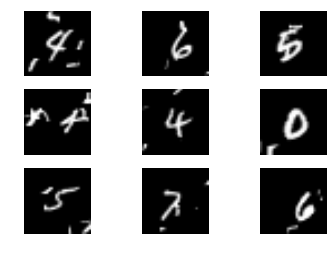

10000/10000 [==============================] - 2s 153us/step
Epoch: 11 | Valid Score: 0.255896358991| Test Score: 0.256612297565| Valid Acc: 0.919 | Test Acc: 0.919


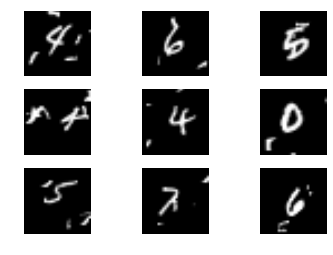

10000/10000 [==============================] - 2s 156us/step
Epoch: 12 | Valid Score: 0.242801029032| Test Score: 0.237844959986| Valid Acc: 0.9237 | Test Acc: 0.9261


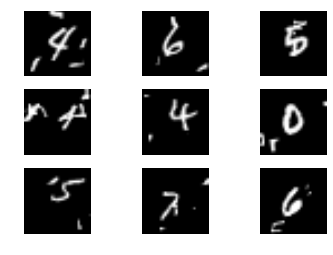

10000/10000 [==============================] - 2s 159us/step
Epoch: 13 | Valid Score: 0.224321169257| Test Score: 0.222730168444| Valid Acc: 0.9285 | Test Acc: 0.9264


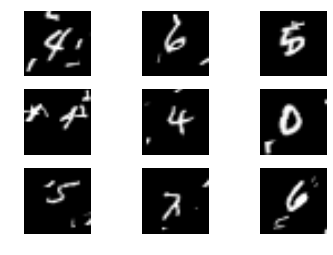

10000/10000 [==============================] - 2s 246us/step
Epoch: 14 | Valid Score: 0.218712406871| Test Score: 0.211546178168| Valid Acc: 0.9324 | Test Acc: 0.9313


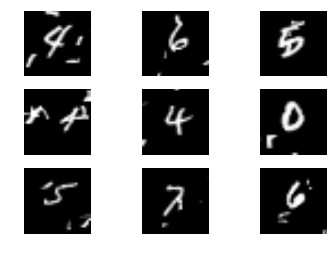

10000/10000 [==============================] - 2s 152us/step
Epoch: 15 | Valid Score: 0.268278445649| Test Score: 0.270896586192| Valid Acc: 0.9144 | Test Acc: 0.9111


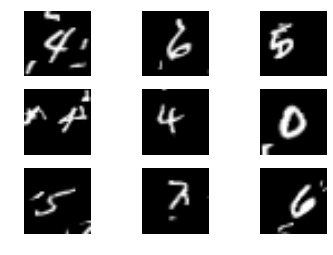

10000/10000 [==============================] - 2s 151us/step
Epoch: 16 | Valid Score: 0.223957018113| Test Score: 0.216732599273| Valid Acc: 0.9294 | Test Acc: 0.9327


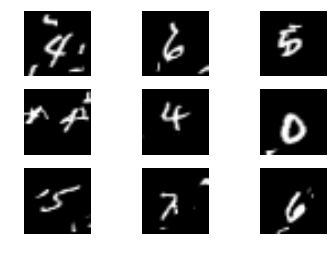

10000/10000 [==============================] - 2s 154us/step
Epoch: 17 | Valid Score: 0.2450790039| Test Score: 0.242634867638| Valid Acc: 0.9248 | Test Acc: 0.9214


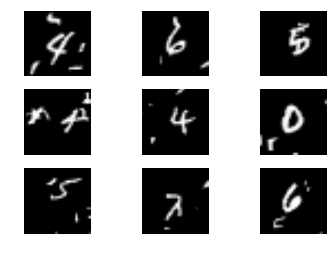

10000/10000 [==============================] - 2s 160us/step
Epoch: 18 | Valid Score: 0.243040357843| Test Score: 0.244349242836| Valid Acc: 0.9274 | Test Acc: 0.9233


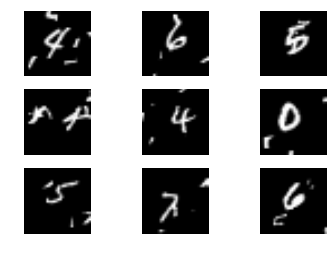

10000/10000 [==============================] - 2s 160us/step
Epoch: 19 | Valid Score: 0.218520246661| Test Score: 0.219300913885| Valid Acc: 0.9332 | Test Acc: 0.9329


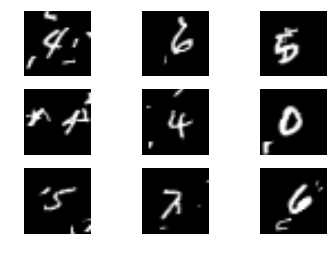

10000/10000 [==============================] - 2s 151us/step
Epoch: 20 | Valid Score: 0.209473543888| Test Score: 0.210333354469| Valid Acc: 0.9351 | Test Acc: 0.9343


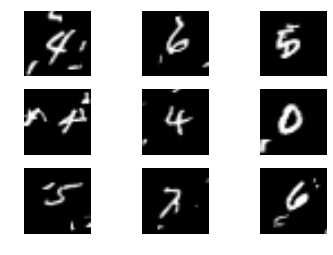

10000/10000 [==============================] - 2s 159us/step
Epoch: 21 | Valid Score: 0.205615116691| Test Score: 0.200940493843| Valid Acc: 0.9375 | Test Acc: 0.9365


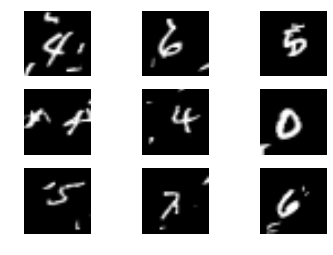

10000/10000 [==============================] - 2s 151us/step
Epoch: 22 | Valid Score: 0.204448349889| Test Score: 0.21326739989| Valid Acc: 0.9369 | Test Acc: 0.9327


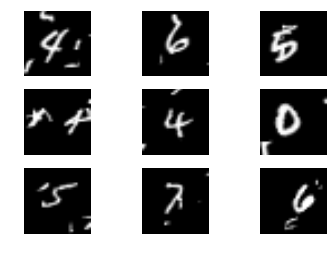

10000/10000 [==============================] - 2s 155us/step
Epoch: 23 | Valid Score: 0.231384591421| Test Score: 0.221709968448| Valid Acc: 0.9303 | Test Acc: 0.9275


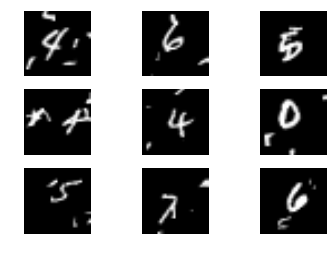

10000/10000 [==============================] - 2s 151us/step
Epoch: 24 | Valid Score: 0.221787626791| Test Score: 0.225427918094| Valid Acc: 0.9317 | Test Acc: 0.9311


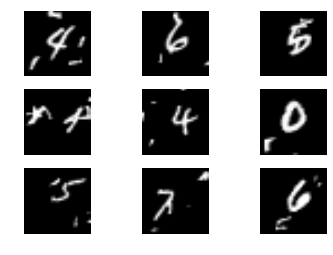

10000/10000 [==============================] - 2s 154us/step
Epoch: 25 | Valid Score: 0.184339585535| Test Score: 0.1787122387| Valid Acc: 0.9425 | Test Acc: 0.9445


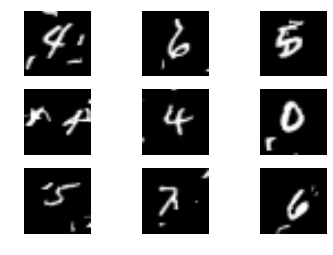

10000/10000 [==============================] - 2s 153us/step
Epoch: 26 | Valid Score: 0.219349493131| Test Score: 0.22128835388| Valid Acc: 0.9321 | Test Acc: 0.9324


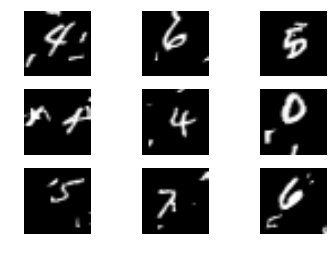

10000/10000 [==============================] - 2s 151us/step
Epoch: 27 | Valid Score: 0.204644083789| Test Score: 0.20420967537| Valid Acc: 0.9379 | Test Acc: 0.9353


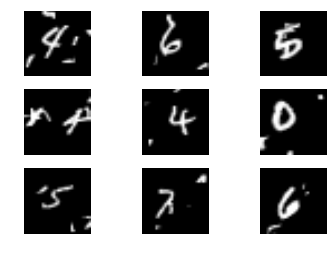

10000/10000 [==============================] - 2s 154us/step
Epoch: 28 | Valid Score: 0.187688023251| Test Score: 0.188070109576| Valid Acc: 0.9451 | Test Acc: 0.9405


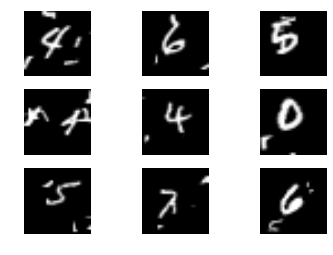

10000/10000 [==============================] - 2s 156us/step
Epoch: 29 | Valid Score: 0.20984094179| Test Score: 0.208414084272| Valid Acc: 0.9375 | Test Acc: 0.938


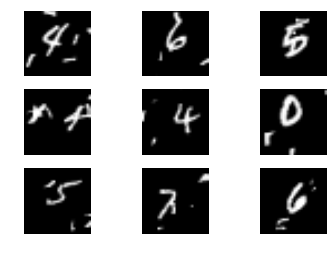

10000/10000 [==============================] - 2s 155us/step
Epoch: 30 | Valid Score: 0.227344980534| Test Score: 0.228626059| Valid Acc: 0.9339 | Test Acc: 0.9316


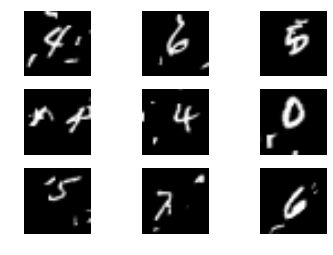

10000/10000 [==============================] - 1s 150us/step
Epoch: 31 | Valid Score: 0.2007519471| Test Score: 0.207327724952| Valid Acc: 0.9419 | Test Acc: 0.9388


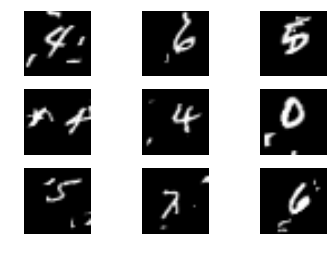

10000/10000 [==============================] - 2s 157us/step
Epoch: 32 | Valid Score: 0.235788517752| Test Score: 0.227558950642| Valid Acc: 0.932 | Test Acc: 0.9325


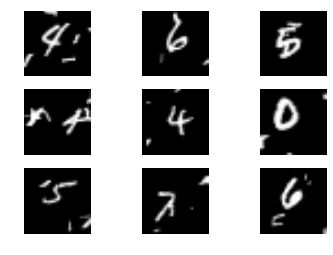

10000/10000 [==============================] - 2s 152us/step
Epoch: 33 | Valid Score: 0.199762888525| Test Score: 0.200301345907| Valid Acc: 0.9415 | Test Acc: 0.9376


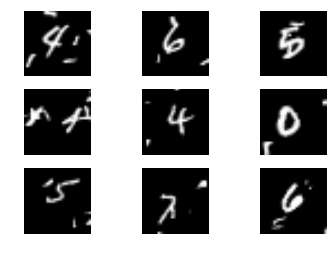

10000/10000 [==============================] - 2s 158us/step
Epoch: 34 | Valid Score: 0.181092150778| Test Score: 0.186874566018| Valid Acc: 0.9469 | Test Acc: 0.9421


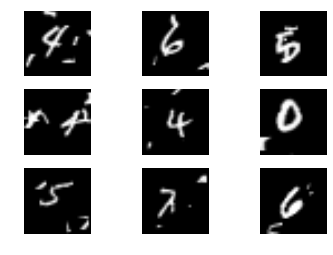

10000/10000 [==============================] - 2s 153us/step
Epoch: 35 | Valid Score: 0.189689967185| Test Score: 0.194457861479| Valid Acc: 0.947 | Test Acc: 0.9421


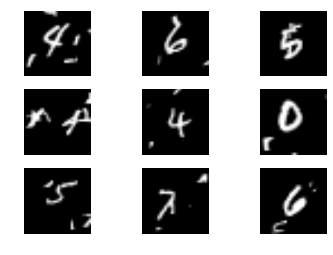

10000/10000 [==============================] - 1s 149us/step
Epoch: 36 | Valid Score: 0.219379993258| Test Score: 0.226211163317| Valid Acc: 0.9394 | Test Acc: 0.9372


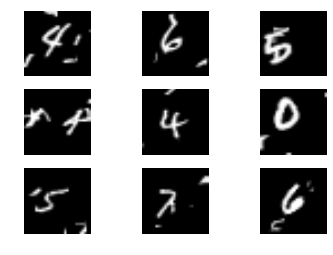

10000/10000 [==============================] - 2s 155us/step
Epoch: 37 | Valid Score: 0.196637614855| Test Score: 0.203506267609| Valid Acc: 0.9428 | Test Acc: 0.9396


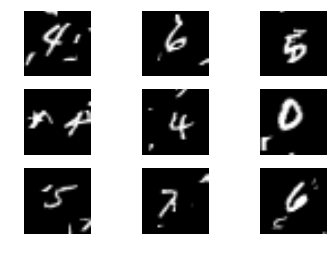

10000/10000 [==============================] - 2s 154us/step
Epoch: 38 | Valid Score: 0.194617626195| Test Score: 0.20108765761| Valid Acc: 0.9477 | Test Acc: 0.9419


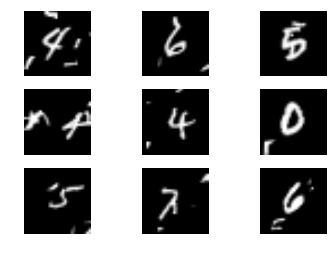

10000/10000 [==============================] - 2s 154us/step
Epoch: 39 | Valid Score: 0.191864423972| Test Score: 0.200418124437| Valid Acc: 0.9454 | Test Acc: 0.944


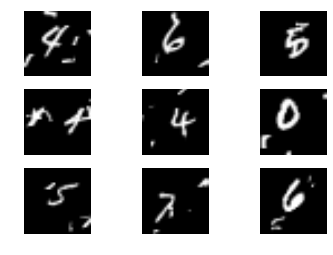

10000/10000 [==============================] - 2s 158us/step
Epoch: 40 | Valid Score: 0.200853386904| Test Score: 0.193256419864| Valid Acc: 0.945 | Test Acc: 0.9446


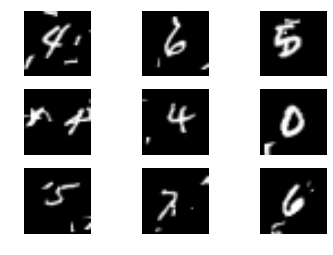

10000/10000 [==============================] - 2s 158us/step
Epoch: 41 | Valid Score: 0.18362688951| Test Score: 0.194670623611| Valid Acc: 0.9498 | Test Acc: 0.9464


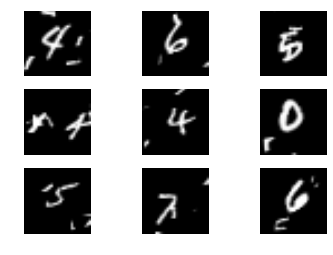

10000/10000 [==============================] - 2s 157us/step
Epoch: 42 | Valid Score: 0.217324396125| Test Score: 0.212119733685| Valid Acc: 0.9393 | Test Acc: 0.9387


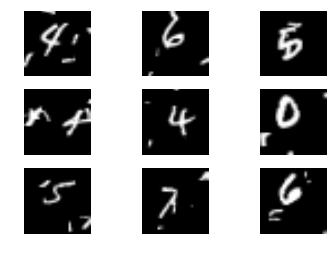

10000/10000 [==============================] - 2s 155us/step
Epoch: 43 | Valid Score: 0.192937947384| Test Score: 0.19519755689| Valid Acc: 0.9456 | Test Acc: 0.9446


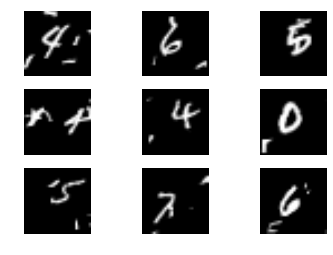

10000/10000 [==============================] - 2s 157us/step
Epoch: 44 | Valid Score: 0.188891737177| Test Score: 0.195500188545| Valid Acc: 0.9492 | Test Acc: 0.9476


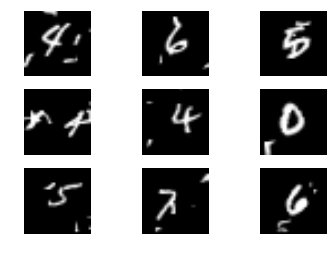

10000/10000 [==============================] - 2s 154us/step
Epoch: 45 | Valid Score: 0.220283929009| Test Score: 0.212925691976| Valid Acc: 0.9448 | Test Acc: 0.9427


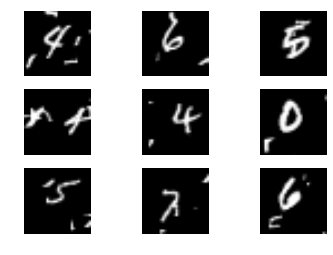

10000/10000 [==============================] - 2s 152us/step
Epoch: 46 | Valid Score: 0.198823352477| Test Score: 0.19780601173| Valid Acc: 0.9471 | Test Acc: 0.9457


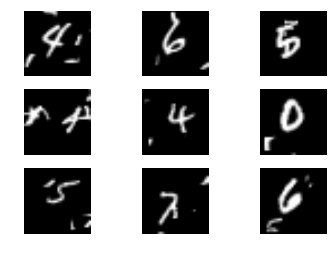

10000/10000 [==============================] - 2s 157us/step
Epoch: 47 | Valid Score: 0.215371070431| Test Score: 0.206892015497| Valid Acc: 0.9419 | Test Acc: 0.9427


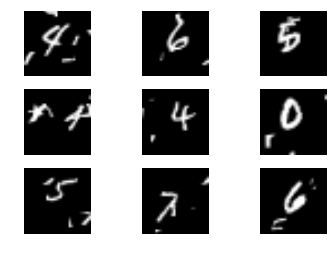

10000/10000 [==============================] - 2s 152us/step
Epoch: 48 | Valid Score: 0.185817490121| Test Score: 0.184150189166| Valid Acc: 0.9499 | Test Acc: 0.9464


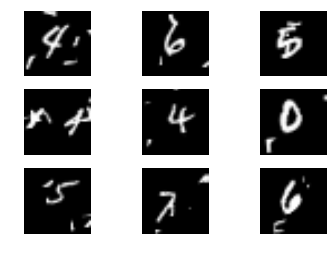

10000/10000 [==============================] - 2s 153us/step
Epoch: 49 | Valid Score: 0.183246267005| Test Score: 0.186626843299| Valid Acc: 0.9498 | Test Acc: 0.9479


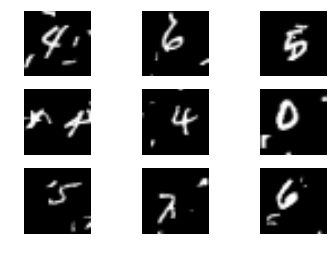

10000/10000 [==============================] - 2s 156us/step
Epoch: 50 | Valid Score: 0.184083218843| Test Score: 0.17477108527| Valid Acc: 0.9525 | Test Acc: 0.9516


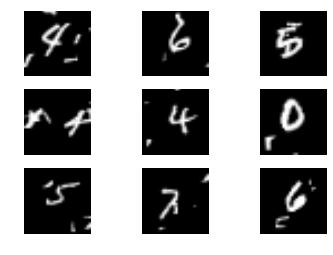

10000/10000 [==============================] - 2s 157us/step
Epoch: 51 | Valid Score: 0.230816940503| Test Score: 0.221226380907| Valid Acc: 0.9432 | Test Acc: 0.9413


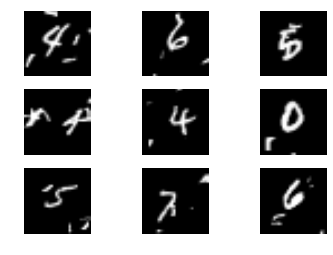

10000/10000 [==============================] - 2s 165us/step
Epoch: 52 | Valid Score: 0.187468258437| Test Score: 0.181765383695| Valid Acc: 0.9504 | Test Acc: 0.9506


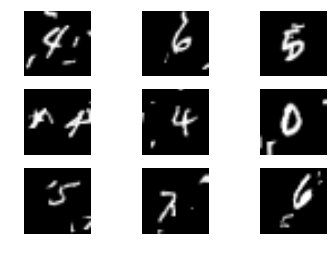

10000/10000 [==============================] - 2s 161us/step
Epoch: 53 | Valid Score: 0.188431706157| Test Score: 0.201867729037| Valid Acc: 0.9513 | Test Acc: 0.9472


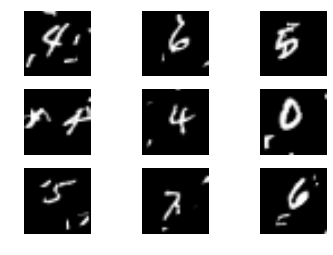

10000/10000 [==============================] - 2s 158us/step
Epoch: 54 | Valid Score: 0.199384509755| Test Score: 0.208320680435| Valid Acc: 0.95 | Test Acc: 0.9449


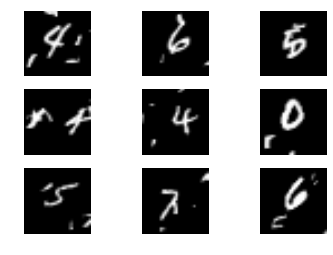

10000/10000 [==============================] - 2s 153us/step
Epoch: 55 | Valid Score: 0.200167880238| Test Score: 0.207036616032| Valid Acc: 0.9483 | Test Acc: 0.9441


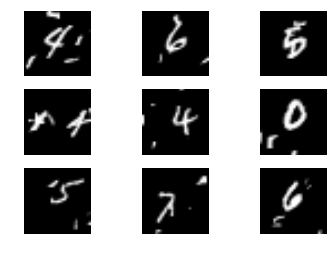

10000/10000 [==============================] - 2s 164us/step
Epoch: 56 | Valid Score: 0.203270387518| Test Score: 0.19521688793| Valid Acc: 0.9479 | Test Acc: 0.9463


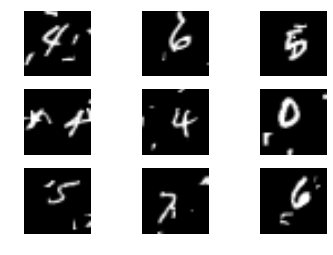

10000/10000 [==============================] - 2s 159us/step
Epoch: 57 | Valid Score: 0.197014551896| Test Score: 0.204329454177| Valid Acc: 0.9511 | Test Acc: 0.9469


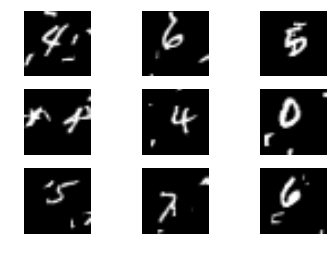

10000/10000 [==============================] - 2s 158us/step
Epoch: 58 | Valid Score: 0.190972614896| Test Score: 0.186119560208| Valid Acc: 0.9501 | Test Acc: 0.9506


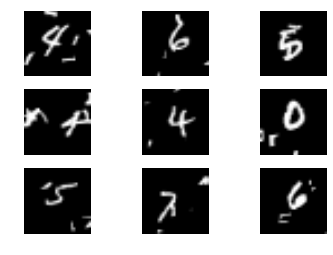

10000/10000 [==============================] - 2s 154us/step
Epoch: 59 | Valid Score: 0.192153306136| Test Score: 0.195368490705| Valid Acc: 0.9499 | Test Acc: 0.9461


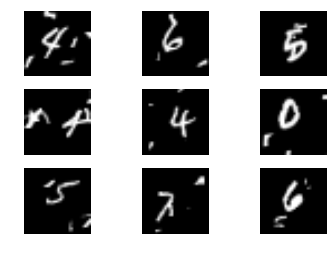

10000/10000 [==============================] - 2s 163us/step
Epoch: 60 | Valid Score: 0.206190286561| Test Score: 0.222461685543| Valid Acc: 0.9506 | Test Acc: 0.9452


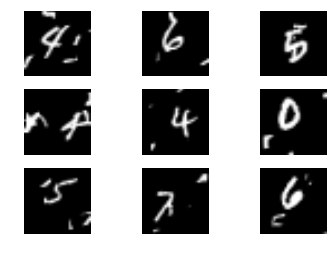

10000/10000 [==============================] - 2s 166us/step
Epoch: 61 | Valid Score: 0.189080736181| Test Score: 0.208127702741| Valid Acc: 0.9511 | Test Acc: 0.9449


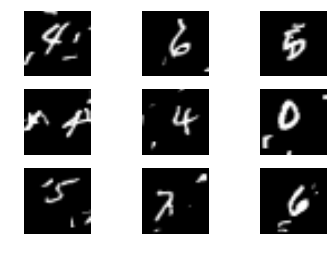

10000/10000 [==============================] - 2s 160us/step
Epoch: 62 | Valid Score: 0.214026089658| Test Score: 0.220115605749| Valid Acc: 0.9496 | Test Acc: 0.9429


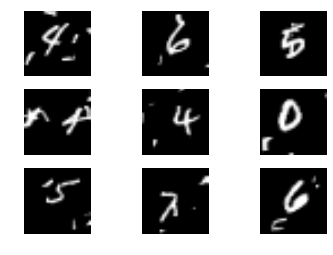

10000/10000 [==============================] - 2s 164us/step
Epoch: 63 | Valid Score: 0.212334228558| Test Score: 0.208894784983| Valid Acc: 0.9463 | Test Acc: 0.9477


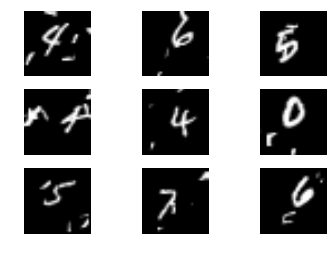

10000/10000 [==============================] - 2s 156us/step
Epoch: 64 | Valid Score: 0.186487729129| Test Score: 0.187003155011| Valid Acc: 0.9507 | Test Acc: 0.9526


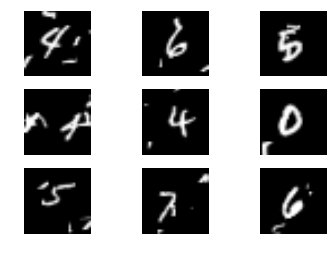

10000/10000 [==============================] - 2s 153us/step
Epoch: 65 | Valid Score: 0.196296088498| Test Score: 0.186512615089| Valid Acc: 0.9501 | Test Acc: 0.9501


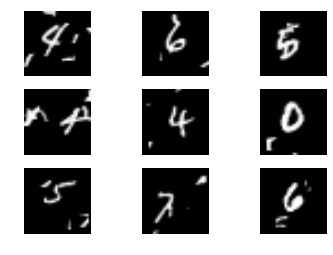

10000/10000 [==============================] - 2s 155us/step
Epoch: 66 | Valid Score: 0.204684113209| Test Score: 0.225123857384| Valid Acc: 0.9475 | Test Acc: 0.9442


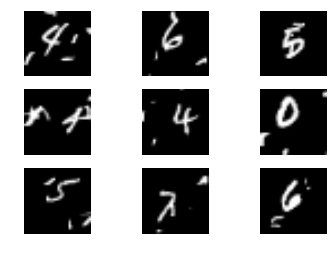

10000/10000 [==============================] - 2s 155us/step
Epoch: 67 | Valid Score: 0.190120017961| Test Score: 0.186205206661| Valid Acc: 0.9533 | Test Acc: 0.9558


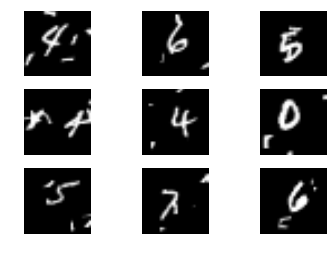

10000/10000 [==============================] - 2s 164us/step
Epoch: 68 | Valid Score: 0.257122754752| Test Score: 0.272970083172| Valid Acc: 0.9399 | Test Acc: 0.9367


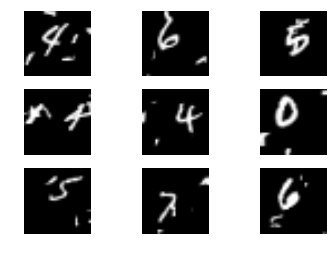

10000/10000 [==============================] - 2s 158us/step
Epoch: 69 | Valid Score: 0.179554859663| Test Score: 0.180363285543| Valid Acc: 0.9565 | Test Acc: 0.9534


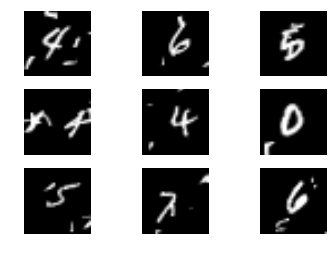

10000/10000 [==============================] - 2s 161us/step
Epoch: 70 | Valid Score: 0.211477560615| Test Score: 0.226983823966| Valid Acc: 0.9479 | Test Acc: 0.9414


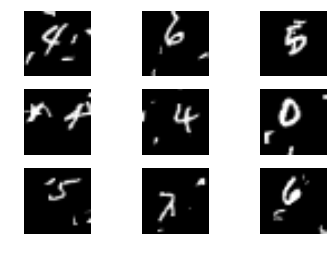

10000/10000 [==============================] - 2s 160us/step
Epoch: 71 | Valid Score: 0.20445955933| Test Score: 0.201825675712| Valid Acc: 0.9505 | Test Acc: 0.9469


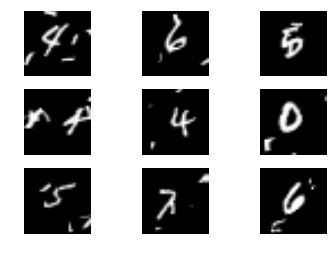

10000/10000 [==============================] - 2s 154us/step
Epoch: 72 | Valid Score: 0.212712148975| Test Score: 0.222297428593| Valid Acc: 0.9481 | Test Acc: 0.9434


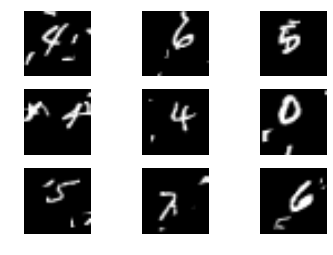

10000/10000 [==============================] - 2s 157us/step
Epoch: 73 | Valid Score: 0.188860110072| Test Score: 0.179794215315| Valid Acc: 0.9536 | Test Acc: 0.9523


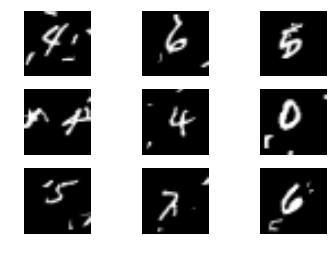

10000/10000 [==============================] - 2s 158us/step
Epoch: 74 | Valid Score: 0.196848768412| Test Score: 0.196206538788| Valid Acc: 0.9481 | Test Acc: 0.9465


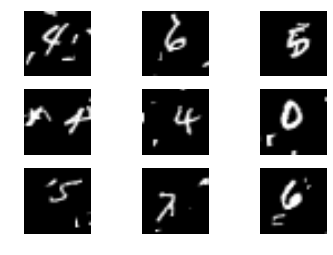

10000/10000 [==============================] - 2s 159us/step
Epoch: 75 | Valid Score: 0.186395940904| Test Score: 0.20309837649| Valid Acc: 0.9498 | Test Acc: 0.9449


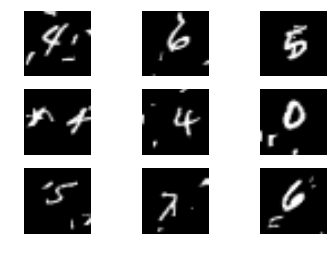

10000/10000 [==============================] - 2s 161us/step
Epoch: 76 | Valid Score: 0.204644725016| Test Score: 0.214131105593| Valid Acc: 0.9488 | Test Acc: 0.9467


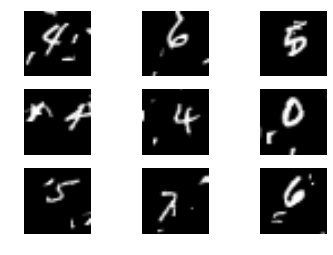

10000/10000 [==============================] - 2s 160us/step
Epoch: 77 | Valid Score: 0.195954373063| Test Score: 0.204301595264| Valid Acc: 0.9515 | Test Acc: 0.9472


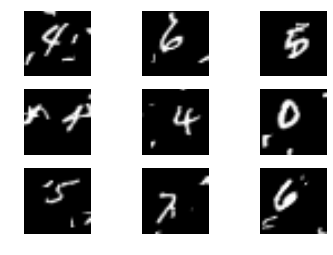

10000/10000 [==============================] - 2s 164us/step
Epoch: 78 | Valid Score: 0.23884470088| Test Score: 0.241294899448| Valid Acc: 0.9466 | Test Acc: 0.9414


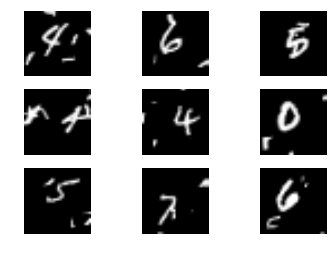

10000/10000 [==============================] - 2s 161us/step
Epoch: 79 | Valid Score: 0.218251417876| Test Score: 0.224137900718| Valid Acc: 0.9495 | Test Acc: 0.9461


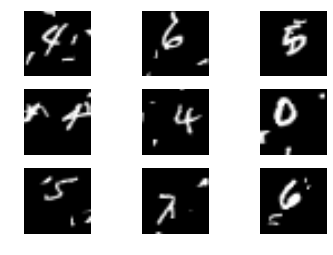

10000/10000 [==============================] - 2s 160us/step
Epoch: 80 | Valid Score: 0.19634273118| Test Score: 0.193461591681| Valid Acc: 0.9541 | Test Acc: 0.9532


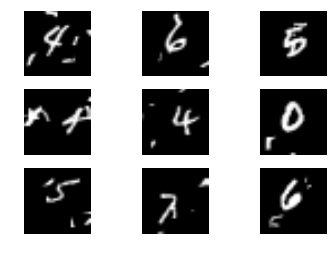

10000/10000 [==============================] - 2s 161us/step
Epoch: 81 | Valid Score: 0.226523838476| Test Score: 0.233400339749| Valid Acc: 0.9505 | Test Acc: 0.9478


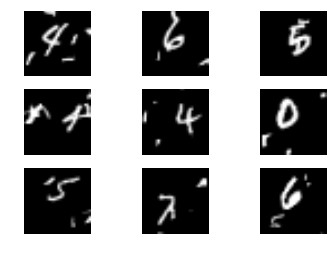

10000/10000 [==============================] - 2s 159us/step
Epoch: 82 | Valid Score: 0.203765357788| Test Score: 0.213043291107| Valid Acc: 0.9512 | Test Acc: 0.9449


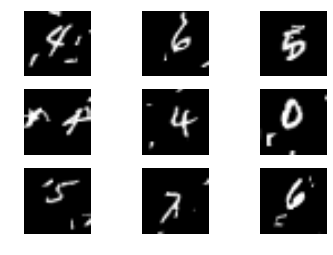

10000/10000 [==============================] - 2s 156us/step
Epoch: 83 | Valid Score: 0.202159164495| Test Score: 0.207221580175| Valid Acc: 0.9506 | Test Acc: 0.947


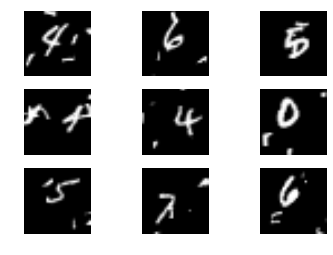

10000/10000 [==============================] - 2s 156us/step
Epoch: 84 | Valid Score: 0.195286246344| Test Score: 0.198093096219| Valid Acc: 0.9525 | Test Acc: 0.9509


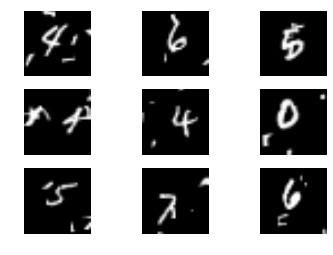

10000/10000 [==============================] - 2s 153us/step
Epoch: 85 | Valid Score: 0.203123605385| Test Score: 0.21327146972| Valid Acc: 0.9503 | Test Acc: 0.9486


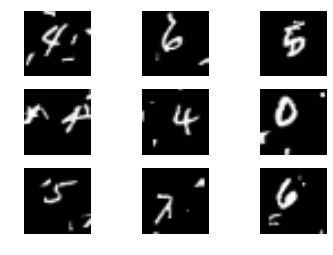

10000/10000 [==============================] - 2s 155us/step
Epoch: 86 | Valid Score: 0.236904613866| Test Score: 0.235119856381| Valid Acc: 0.9493 | Test Acc: 0.9476


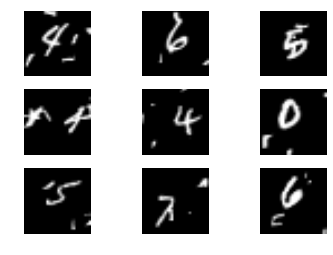

10000/10000 [==============================] - 2s 153us/step
Epoch: 87 | Valid Score: 0.209112152962| Test Score: 0.215577150863| Valid Acc: 0.9505 | Test Acc: 0.9482


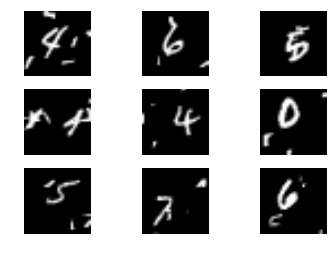

10000/10000 [==============================] - 2s 158us/step
Epoch: 88 | Valid Score: 0.229593309231| Test Score: 0.238568550785| Valid Acc: 0.9496 | Test Acc: 0.9429


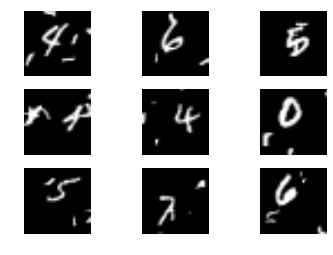

10000/10000 [==============================] - 2s 156us/step
Epoch: 89 | Valid Score: 0.252015063938| Test Score: 0.256950573105| Valid Acc: 0.9388 | Test Acc: 0.9331


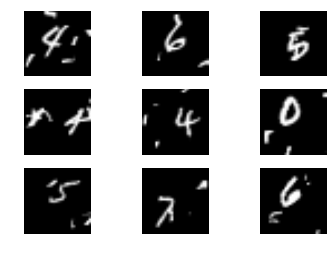

10000/10000 [==============================] - 2s 155us/step
Epoch: 90 | Valid Score: 0.234654121231| Test Score: 0.227877295049| Valid Acc: 0.9427 | Test Acc: 0.9451


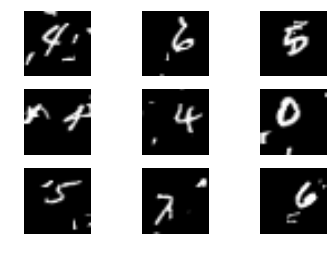

10000/10000 [==============================] - 2s 156us/step
Epoch: 91 | Valid Score: 0.242746989134| Test Score: 0.238305267803| Valid Acc: 0.9467 | Test Acc: 0.9433


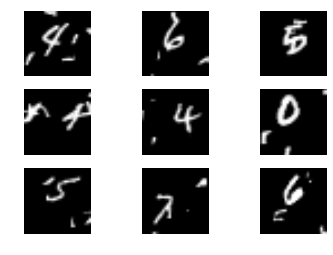

10000/10000 [==============================] - 2s 153us/step
Epoch: 92 | Valid Score: 0.221945383239| Test Score: 0.227467897624| Valid Acc: 0.9479 | Test Acc: 0.9471


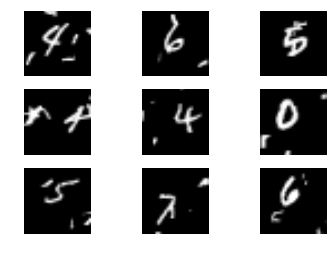

10000/10000 [==============================] - 2s 159us/step
Epoch: 93 | Valid Score: 0.239329219275| Test Score: 0.257035154492| Valid Acc: 0.9475 | Test Acc: 0.9423


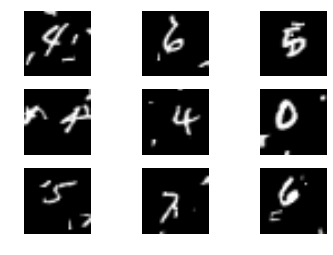

10000/10000 [==============================] - 2s 150us/step
Epoch: 94 | Valid Score: 0.239723617707| Test Score: 0.247433372105| Valid Acc: 0.948 | Test Acc: 0.9458


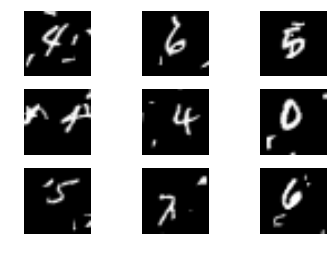

10000/10000 [==============================] - 2s 157us/step
Epoch: 95 | Valid Score: 0.194882716053| Test Score: 0.200007154333| Valid Acc: 0.953 | Test Acc: 0.95


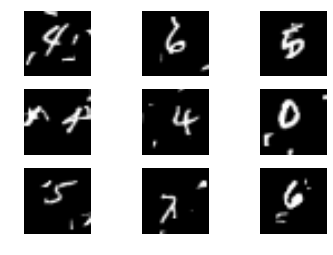

10000/10000 [==============================] - 1s 149us/step
Epoch: 96 | Valid Score: 0.209188307008| Test Score: 0.215779148831| Valid Acc: 0.9525 | Test Acc: 0.9474


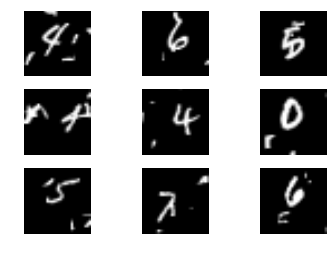

10000/10000 [==============================] - 2s 153us/step
Epoch: 97 | Valid Score: 0.214648427572| Test Score: 0.197286954377| Valid Acc: 0.9478 | Test Acc: 0.9483


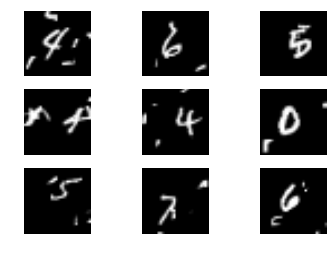

10000/10000 [==============================] - 2s 155us/step
Epoch: 98 | Valid Score: 0.264770954386| Test Score: 0.252874493555| Valid Acc: 0.939 | Test Acc: 0.9397


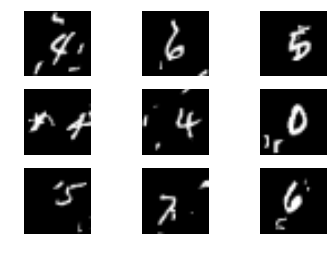

10000/10000 [==============================] - 2s 152us/step
Epoch: 99 | Valid Score: 0.208090578804| Test Score: 0.21475433484| Valid Acc: 0.9487 | Test Acc: 0.9453


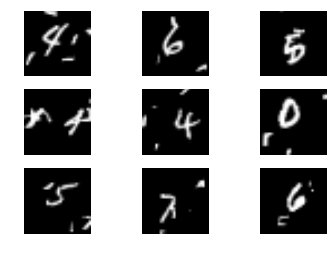

In [11]:
nb_epochs = 100 # you probably want to go longer than this
batch_size = 256
fig = plt.figure()
try:
    for e in range(nb_epochs):
#         print('-'*40)
        #progbar = generic_utils.Progbar(X_train.shape[0])
        for b in range(150):
            #print(b)
            f = b * batch_size
            l = (b+1) * batch_size
            X_batch = X_train[f:l].astype('float32')
            y_batch = y_train[f:l].astype('float32')
            loss = model.train_on_batch(X_batch, y_batch)
            #print(loss)
            #progbar.add(X_batch.shape[0], values=[("train loss", loss)])
        scorev, accv = model.evaluate(X_valid, y_valid, verbose=1)
        scoret, acct = model.evaluate(X_test, y_test, verbose=1)
        if(e%1==0):
            print('Epoch: {0} | Valid Score: {1}| Test Score: {2}| Valid Acc: {3} | Test Acc: {4}'.format(e, scorev, scoret, accv, acct))
        
        if e % 1 == 0:
            # The output of the intermediate spatial transformation layer
            Xresult = F([X_batch[:9]])
            plt.clf()
            for i in range(9):
                plt.subplot(3, 3, i+1)
                image = np.squeeze(Xresult[0][i])
                plt.imshow(image, cmap='gray')
                plt.axis('off')
            fig.canvas.draw()
            plt.show()
        
except KeyboardInterrupt:
    pass

### Visualizing what the Spatial Transformer learned

In [14]:
Xaug = X_train[:9]
Xresult = F([Xaug.astype('float32')])

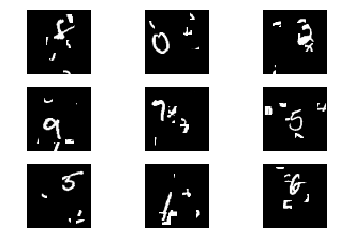

In [15]:
# input
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(np.squeeze(Xaug[i]), cmap='gray')
    plt.axis('off')

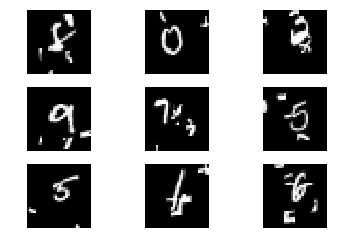

In [16]:
# output
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(np.squeeze(Xresult[0][i]), cmap='gray')
    plt.axis('off')

In [21]:
w = 3
h = 2
import numpy as np

In [22]:
x = np.linspace(0,1,w)
y = np.linspace(-3,-2,h)

In [23]:
x_t, y_t = np.meshgrid(x, y)

In [24]:
x

array([0. , 0.5, 1. ])

In [25]:
y

array([-3., -2.])

In [26]:
x_t

array([[0. , 0.5, 1. ],
       [0. , 0.5, 1. ]])

In [27]:
y_t

array([[-3., -3., -3.],
       [-2., -2., -2.]])

In [28]:
ones = np.ones(np.prod(x_t.shape))


In [29]:
sampling_grid = np.vstack([x_t.flatten(), y_t.flatten(), ones])
sampling_grid

array([[ 0. ,  0.5,  1. ,  0. ,  0.5,  1. ],
       [-3. , -3. , -3. , -2. , -2. , -2. ],
       [ 1. ,  1. ,  1. ,  1. ,  1. ,  1. ]])